# Meuse Data package Data Exploration (With Log transformation)

In [1]:
import pandas as pd
import os
from pathlib import Path
import Data
import coordinates

In [2]:
currpath = os.getcwd()
mypath = Path().absolute().parent # each '.parent' goes one level up - vary as required
#print(mypath)
#os.chdir(mypath)
os.chdir(os.path.dirname(os.path.abspath("meuse_data.csv")))
print(Path().absolute())

C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


## Data Package Introduction

The meuse data set provided by package sp is a data set comprising of four heavy metals measured in the top soil in a flood plain along the river Meuse, along with a handful of covariates.

In [3]:
meuse_df = pd.read_csv("Data/meuse_data.csv")
meuse_df.describe()

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,dist.m
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,153.000000,155.000000,155.000000,155.000000,155.000000
mean,180004.600000,331634.935484,3.245806,40.316129,153.361290,469.716129,8.165394,0.240017,7.478431,1.606452,1.451613,0.283871,290.322581
std,746.039775,1047.746801,3.523746,23.680436,111.320054,367.073788,1.058657,0.197702,3.432966,0.734111,0.636483,0.452336,226.799927
min,178605.000000,329714.000000,0.200000,14.000000,37.000000,113.000000,5.180000,0.000000,1.000000,1.000000,1.000000,0.000000,10.000000
25%,179371.000000,330762.000000,0.800000,23.000000,72.500000,198.000000,7.546000,0.075687,5.300000,1.000000,1.000000,0.000000,80.000000
50%,179991.000000,331633.000000,2.100000,31.000000,123.000000,326.000000,8.180000,0.211843,6.900000,1.000000,1.000000,0.000000,270.000000
75%,180629.500000,332463.000000,3.850000,49.500000,207.000000,674.500000,8.955000,0.364067,9.000000,2.000000,2.000000,1.000000,450.000000
max,181390.000000,333611.000000,18.100000,128.000000,654.000000,1839.000000,10.520000,0.880389,17.000000,3.000000,3.000000,1.000000,1000.000000


## Missing values

In [4]:
Data = meuse_df.copy()
missing_values=Data.isnull().sum()
print(missing_values)

x          0
y          0
cadmium    0
copper     0
lead       0
zinc       0
elev       0
dist       0
om         2
ffreq      0
soil       0
lime       0
landuse    1
dist.m     0
dtype: int64


Since the missing values are in columns that are not the focus area, these missing values will be ignored.

In [5]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np
import shapely
import seaborn as sns

## Plotting Spatial distributions of each metal (Original dataset)

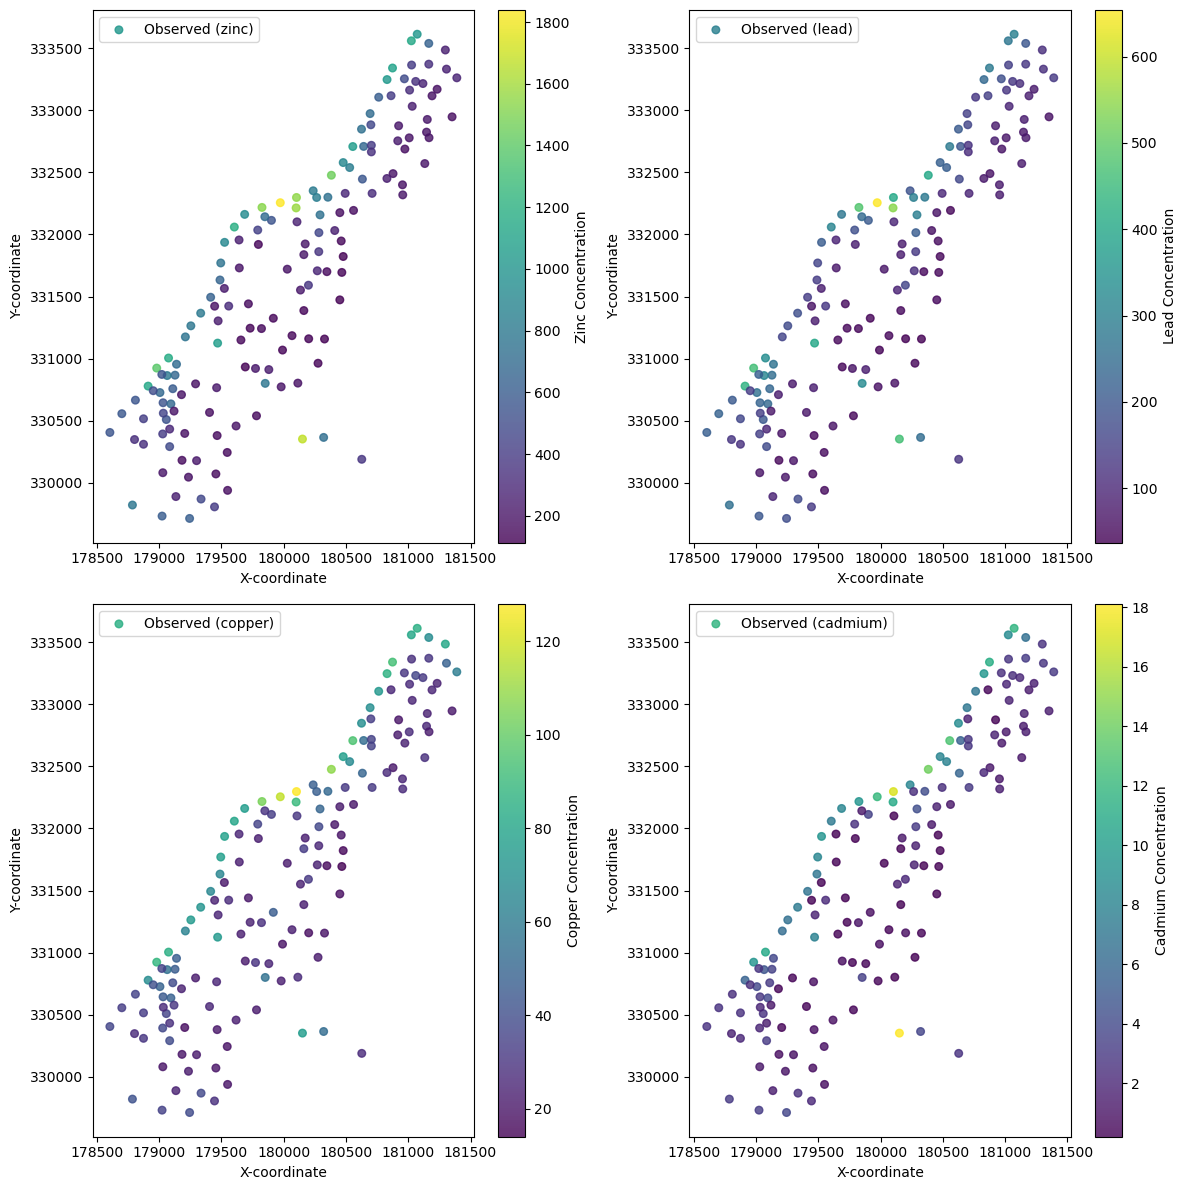

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# List of metal elements
metal_elements = ['zinc', 'lead', 'copper', 'cadmium']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, metal_element in enumerate(metal_elements):
    metal_values = meuse_df[metal_element]

    # Scatter plot with color bar for each metal element
    scatter_plot = axs[i].scatter(meuse_df['x'], meuse_df['y'], c=metal_values, cmap='viridis',label=f'Observed ({metal_element})', marker='o', s=30, alpha=0.8)

    # Add color bar for metal concentrations
    cbar = plt.colorbar(scatter_plot, ax=axs[i], label=f'{metal_element.capitalize()} Concentration')

    # Set labels and legend
    axs[i].set_xlabel('X-coordinate')
    axs[i].set_ylabel('Y-coordinate')
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Identifying outliers

In [7]:
def remove_outlier(dt, var):
    # Create the dataframe
    cleaned_dt = dt.copy()
    print("Old Shape: ", dt.shape)

    ''' Detection '''
    # IQR
    # Calculate the upper and lower limits
    Q1 = dt[var].quantile(0.25)
    Q3 = dt[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outlier_indices = np.where((dt[var] < lower_limit) | (dt[var] > upper_limit))[0]
    print("Number of outliers:", len(outlier_indices))

    # Remove outliers completely
    cleaned_dt = cleaned_dt.drop(index=outlier_indices).reset_index(drop=True)

    # Print the new shape of the DataFrame
    print("New Shape: ", cleaned_dt.shape)

    print("Skewness before cleaning:", dt[var].skew())
    print("Skewness after cleaning:", cleaned_dt[var].skew())

    return outlier_indices, cleaned_dt

Old Shape:  (155, 14)
Number of outliers: 6
New Shape:  (149, 14)
Skewness before cleaning: 1.4864620347342794
Skewness after cleaning: 1.0648562367388361
Old Shape:  (155, 14)
Number of outliers: 7
New Shape:  (148, 14)
Skewness before cleaning: 1.4140545748691198
Skewness after cleaning: 1.1903176662977377
Old Shape:  (155, 14)
Number of outliers: 15
New Shape:  (140, 14)
Skewness before cleaning: 1.796224721237889
Skewness after cleaning: 1.3172285372033492
Old Shape:  (155, 14)
Number of outliers: 6
New Shape:  (149, 14)
Skewness before cleaning: 1.652336453693943
Skewness after cleaning: 1.0046749568112665


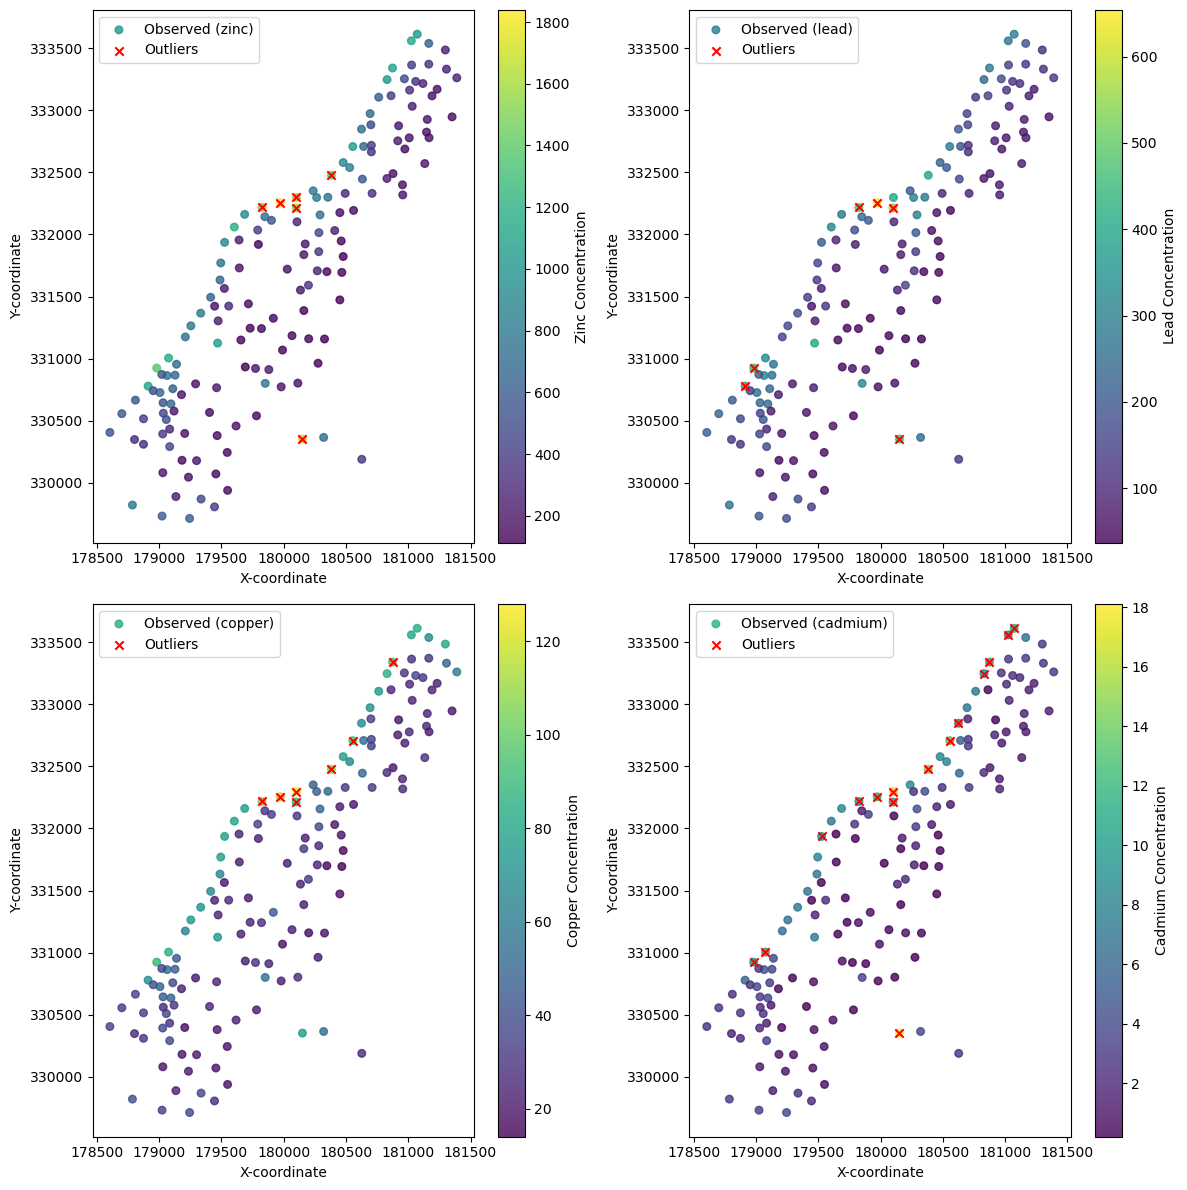

In [8]:
outliers_zinc, cleaned_zinc = remove_outlier(meuse_df,'zinc')
outliers_copper, cleaned_copper = remove_outlier(meuse_df,'copper')
outliers_cadmium, cleaned_cadmium = remove_outlier(meuse_df,'cadmium')
outliers_lead, cleaned_lead = remove_outlier(meuse_df,'lead')


# List of metal elements
metal_elements = ['zinc', 'lead', 'copper', 'cadmium']
outliers = [outliers_zinc,outliers_lead,outliers_copper,outliers_cadmium]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, metal_element in enumerate(metal_elements):
    metal_values = meuse_df[metal_element]
    outlier = outliers[i]

    #Note: The order of the below lines of code matters, as it will result in either the cross appearing behind the plotted points or the axis of color bar not plotted according to the actual range of each metal element
    
    # Scatter plot with color bar for each metal element
    scatter_plot = axs[i].scatter(meuse_df['x'], meuse_df['y'], c=metal_values, cmap='viridis',label=f'Observed ({metal_element})', marker='o', s=30, alpha=0.8)
    
    # Add color bar for metal concentrations
    cbar = plt.colorbar(scatter_plot, ax=axs[i], label=f'{metal_element.capitalize()} Concentration')
    
    scatter_plot = axs[i].scatter(meuse_df.loc[outlier, 'x'], meuse_df.loc[outlier, 'y'], marker='x', c='red', label = 'Outliers')

    # Set labels and legend
    axs[i].set_xlabel('X-coordinate')
    axs[i].set_ylabel('Y-coordinate')
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [9]:
def show_outlier(dt, var):
    var_name = dt[var]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.boxplot(x=var_name)
    plt.title('With outliers')

    plt.subplot(2, 2, 2)
    sns.histplot(x=var_name, kde=True)
    plt.title('With outliers')

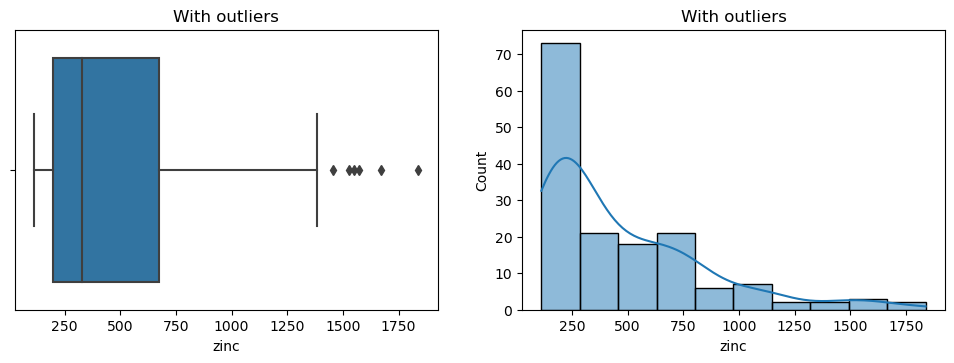

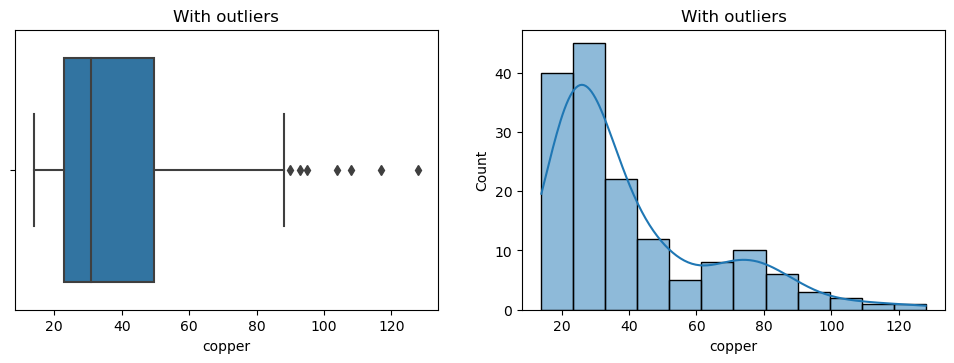

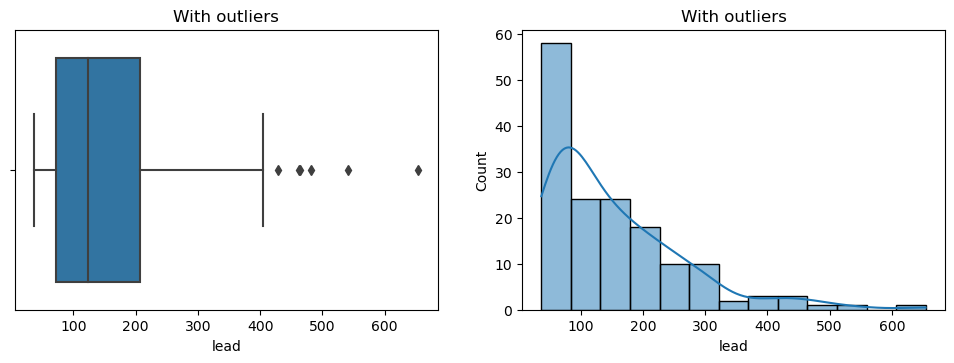

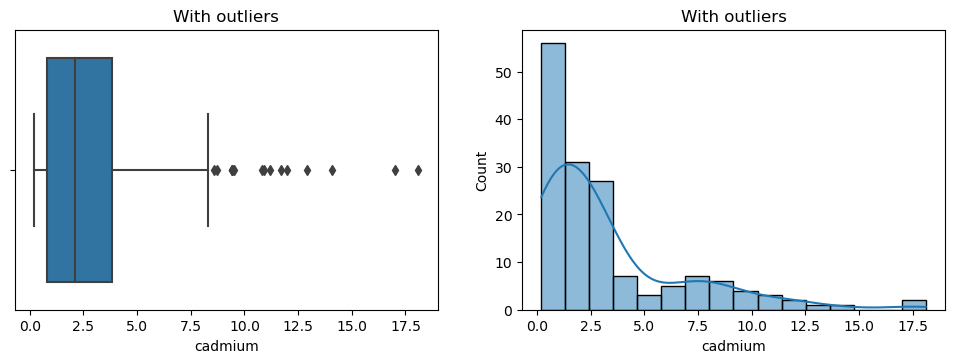

In [10]:
show_outlier(meuse_df,'zinc')
show_outlier(meuse_df,'copper')
show_outlier(meuse_df,'lead')
show_outlier(meuse_df,'cadmium')

# Log Transformation

In [11]:
log_transformed = meuse_df.copy()
log_transformed['zinc'] = np.log(log_transformed['zinc'])
log_transformed['lead'] = np.log(log_transformed['lead'])
log_transformed['copper'] = np.log(log_transformed['copper'])
log_transformed['cadmium'] = np.log(log_transformed['cadmium'])

log_outliers_zinc, log_cleaned_zinc = remove_outlier(log_transformed,'zinc')
log_outliers_lead, log_cleaned_lead = remove_outlier(log_transformed,'lead')
log_outliers_copper, log_cleaned_copper = remove_outlier(log_transformed,'copper')
log_outliers_cadmium, log_cleaned_cadmium = remove_outlier(log_transformed,'cadmium')

Old Shape:  (155, 14)
Number of outliers: 0
New Shape:  (155, 14)
Skewness before cleaning: 0.329074831243989
Skewness after cleaning: 0.329074831243989
Old Shape:  (155, 14)
Number of outliers: 0
New Shape:  (155, 14)
Skewness before cleaning: 0.25542087238264755
Skewness after cleaning: 0.25542087238264755
Old Shape:  (155, 14)
Number of outliers: 0
New Shape:  (155, 14)
Skewness before cleaning: 0.6675678984828443
Skewness after cleaning: 0.6675678984828443
Old Shape:  (155, 14)
Number of outliers: 0
New Shape:  (155, 14)
Skewness before cleaning: -0.3375549664912751
Skewness after cleaning: -0.3375549664912751


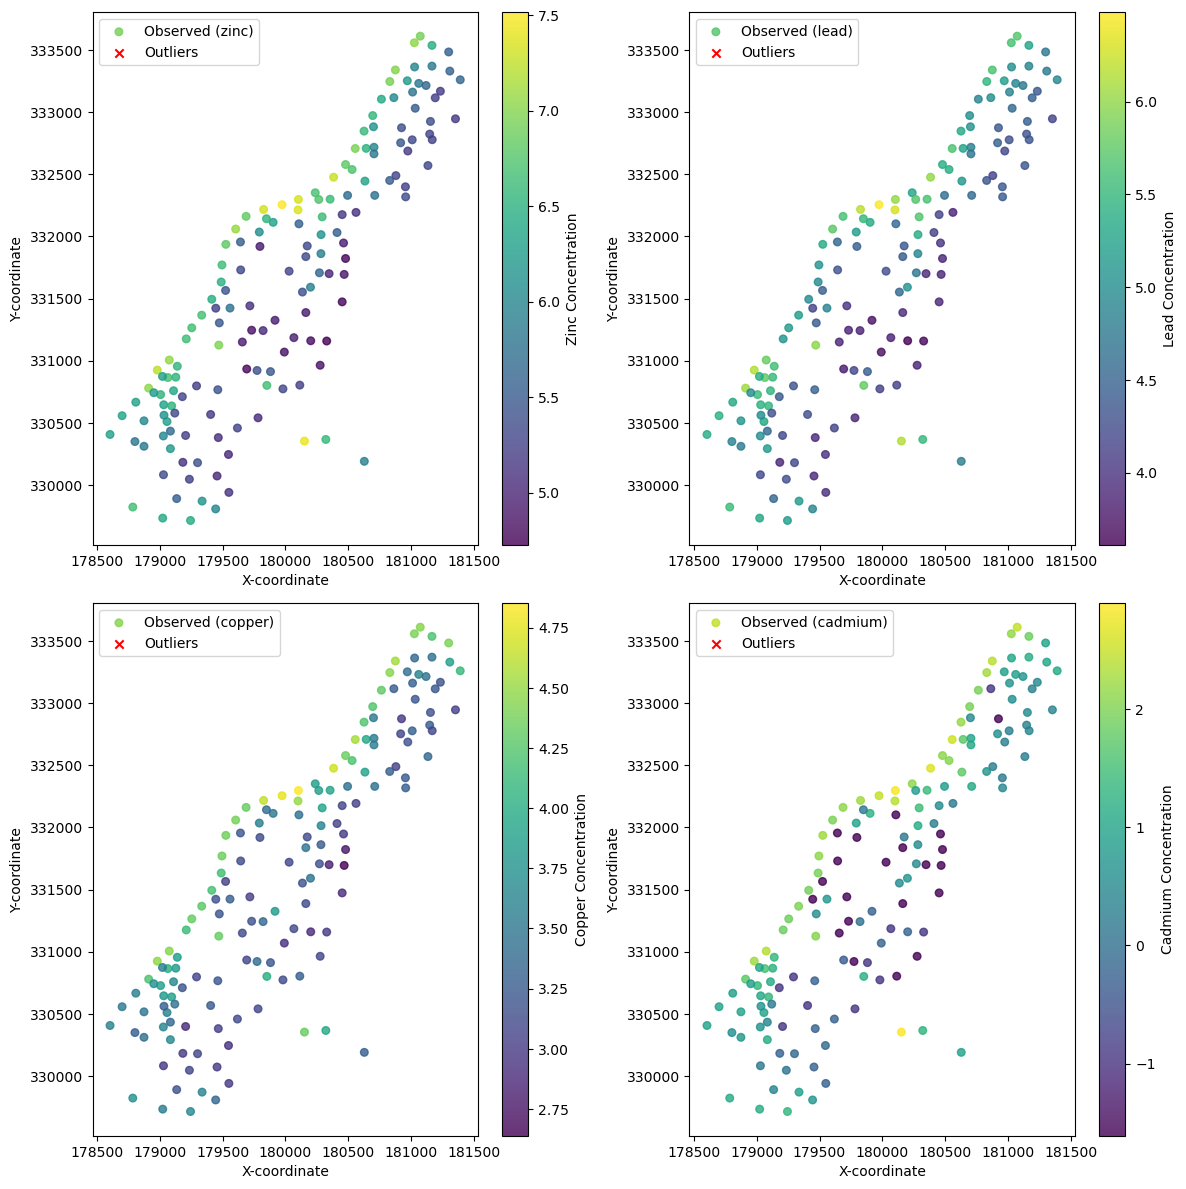

In [12]:
# List of metal elements
metal_elements = ['zinc', 'lead', 'copper', 'cadmium']
outliers = [log_outliers_zinc,log_outliers_lead,log_outliers_copper,log_outliers_cadmium]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, metal_element in enumerate(metal_elements):
    metal_values = log_transformed[metal_element]
    outlier = outliers[i]

    #Note: The order of the below lines of code matters, as it will result in either the cross appearing behind the plotted points or the axis of color bar not plotted according to the actual range of each metal element
    
    # Scatter plot with color bar for each metal element
    scatter_plot = axs[i].scatter(log_transformed['x'], log_transformed['y'], c=metal_values, cmap='viridis',label=f'Observed ({metal_element})', marker='o', s=30, alpha=0.8)
    
    # Add color bar for metal concentrations
    cbar = plt.colorbar(scatter_plot, ax=axs[i], label=f'{metal_element.capitalize()} Concentration')
    
    scatter_plot = axs[i].scatter(log_transformed.loc[outlier, 'x'], log_transformed.loc[outlier, 'y'], marker='x', c='red', label = 'Outliers')

    # Set labels and legend
    axs[i].set_xlabel('X-coordinate')
    axs[i].set_ylabel('Y-coordinate')
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [13]:
def show_outlier(dt, var):
    var_name = dt[var]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.boxplot(x=var_name)
    plt.title('After Log Transformation')

    plt.subplot(2, 2, 2)
    sns.histplot(x=var_name, kde=True)
    plt.title('After Log Transformation')

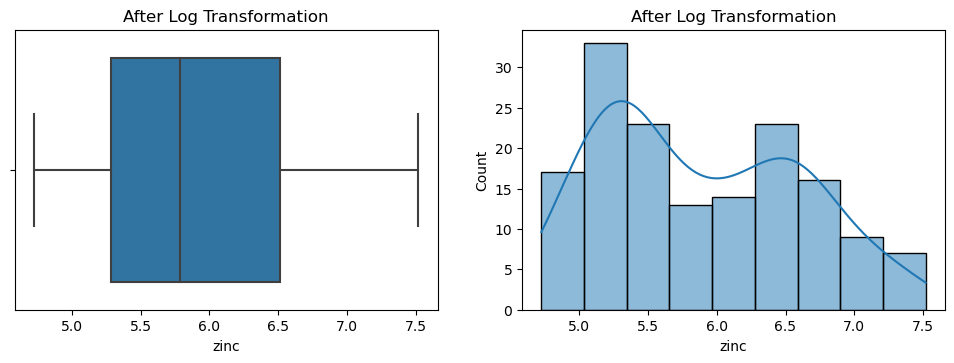

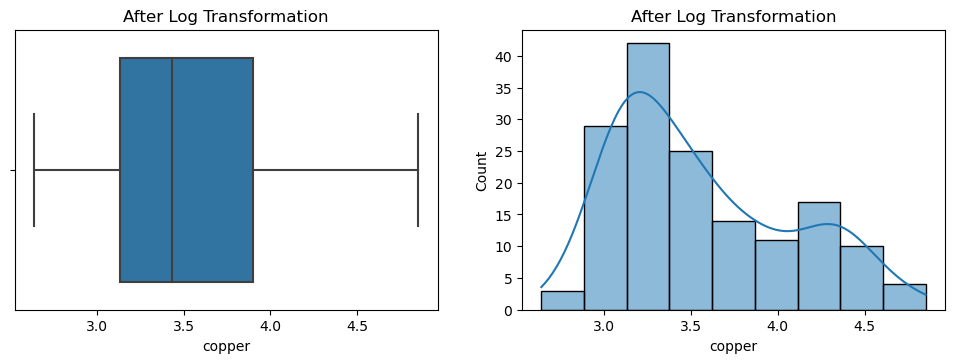

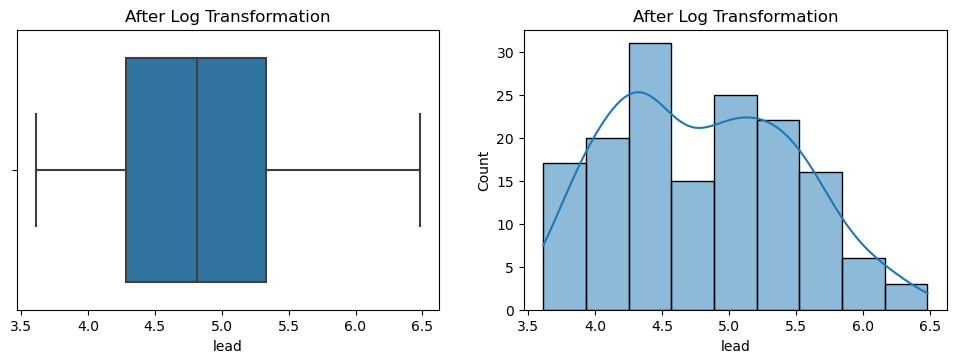

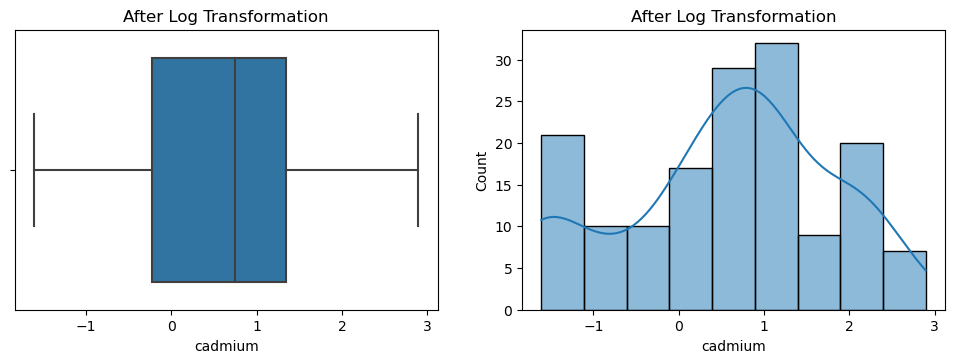

In [14]:
show_outlier(log_transformed,'zinc')
show_outlier(log_transformed,'copper')
show_outlier(log_transformed,'lead')
show_outlier(log_transformed,'cadmium')

In [15]:
print(log_transformed['x'])

0      181072
1      181025
2      181165
3      181298
4      181307
        ...  
150    179184
151    179085
152    178875
153    179466
154    180627
Name: x, Length: 155, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans

n_list = [2,3,4,5,6,7,8]
parameters = [
    {'n_clusters': n_list}
]
kmeans = KMeans(n_init = 10)
clf = GridSearchCV(estimator = kmeans, param_grid = parameters)
clf.fit(log_transformed[['x', 'y']])
best_n_clusters = clf.best_estimator_.n_clusters
print("Number of clusters: ", best_n_clusters)
log_transformed['cluster_num'] = clf.best_estimator_.labels_

C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\chloe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

Number of clusters:  8


In [17]:
print(log_transformed['x'])

0      181072
1      181025
2      181165
3      181298
4      181307
        ...  
150    179184
151    179085
152    178875
153    179466
154    180627
Name: x, Length: 155, dtype: int64


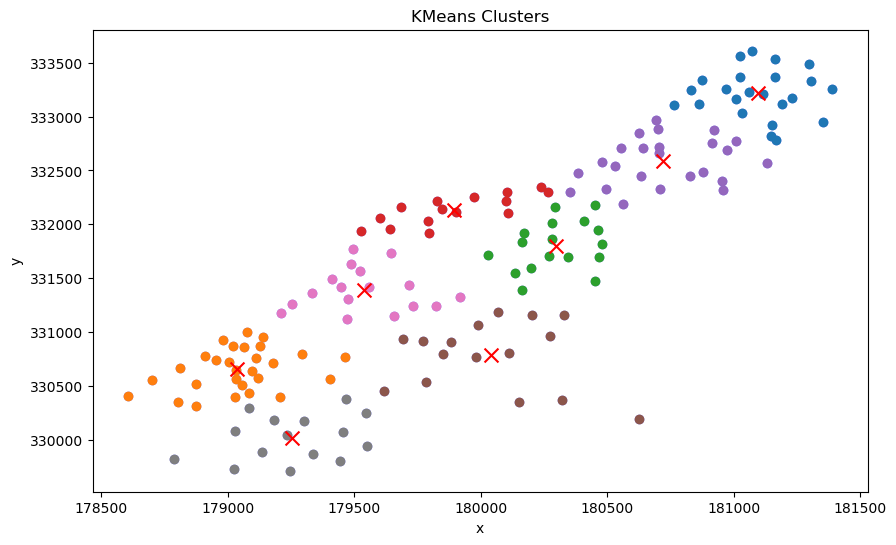

In [24]:
centers = clf.best_estimator_.cluster_centers_

plt.figure(figsize=(10, 6))

# Plotting the original data points
plt.scatter(log_transformed['x'], log_transformed['y'], color='blue', alpha=0.5, label='Original Data')


# Plot each cluster with a different color
for cluster in range(best_n_clusters):
    cluster_data = log_transformed[log_transformed['cluster_num'] == cluster]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='red', label='Centers', marker='x')

plt.title('KMeans Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [25]:
log_transformed.to_csv('meuse_processed.csv', index=False)

In [26]:
display(log_transformed)

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,cluster_num
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50,0
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30,0
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150,0
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270,0
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540,7
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520,7
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350,1
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460,7


# Other useful plots

## Scatter Plot with trend surface (Zinc)

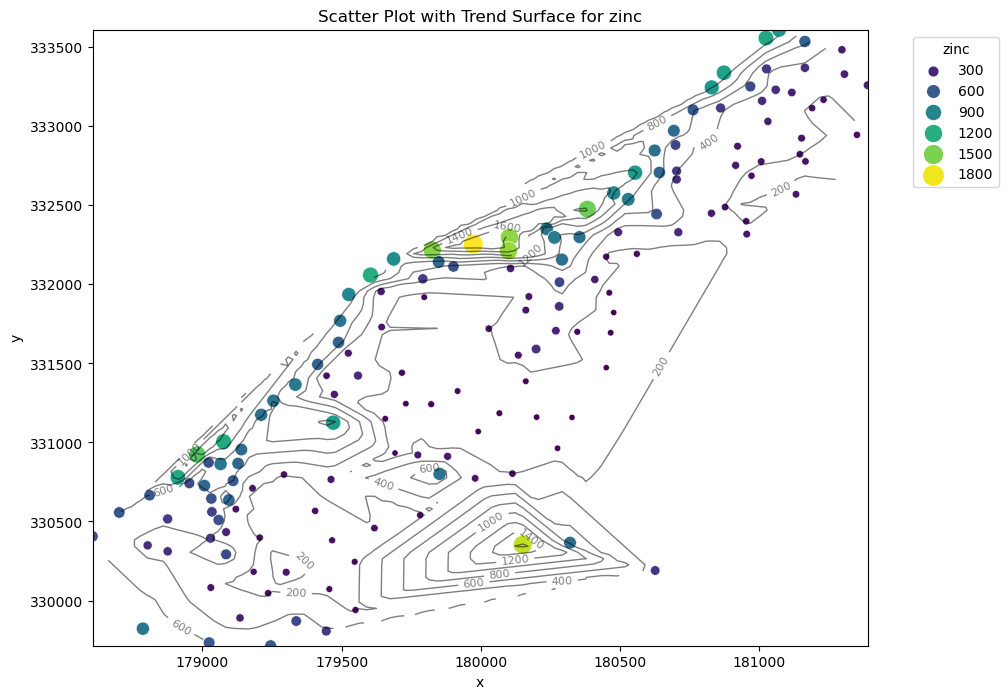

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


# Select variables of interest
x_variable = 'x'  # Replace with the actual variable name
y_variable = 'y'  # Replace with the actual variable name
z_variable = 'zinc'  # Replace with the actual variable name

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_variable, y=y_variable, hue=z_variable, data=meuse_df, palette='viridis', size=z_variable, sizes=(20, 200))

# Add a trend surface using griddata
x_range = np.linspace(meuse_df[x_variable].min(), meuse_df[x_variable].max(), 100)
y_range = np.linspace(meuse_df[y_variable].min(), meuse_df[y_variable].max(), 100)
xx, yy = np.meshgrid(x_range, y_range)
points = np.array(meuse_df[[x_variable, y_variable]])
values = np.array(meuse_df[z_variable])
zz = griddata(points, values, (xx, yy), method='linear')

# Contour plot of the trend surface
contour = plt.contour(xx, yy, zz, levels=10, colors='black', linewidths=1, alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

plt.title(f'Scatter Plot with Trend Surface for {z_variable}')
plt.xlabel(x_variable)
plt.ylabel(y_variable)
plt.legend(title=z_variable, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Relationship between the different metals (Log Transformed dataset)

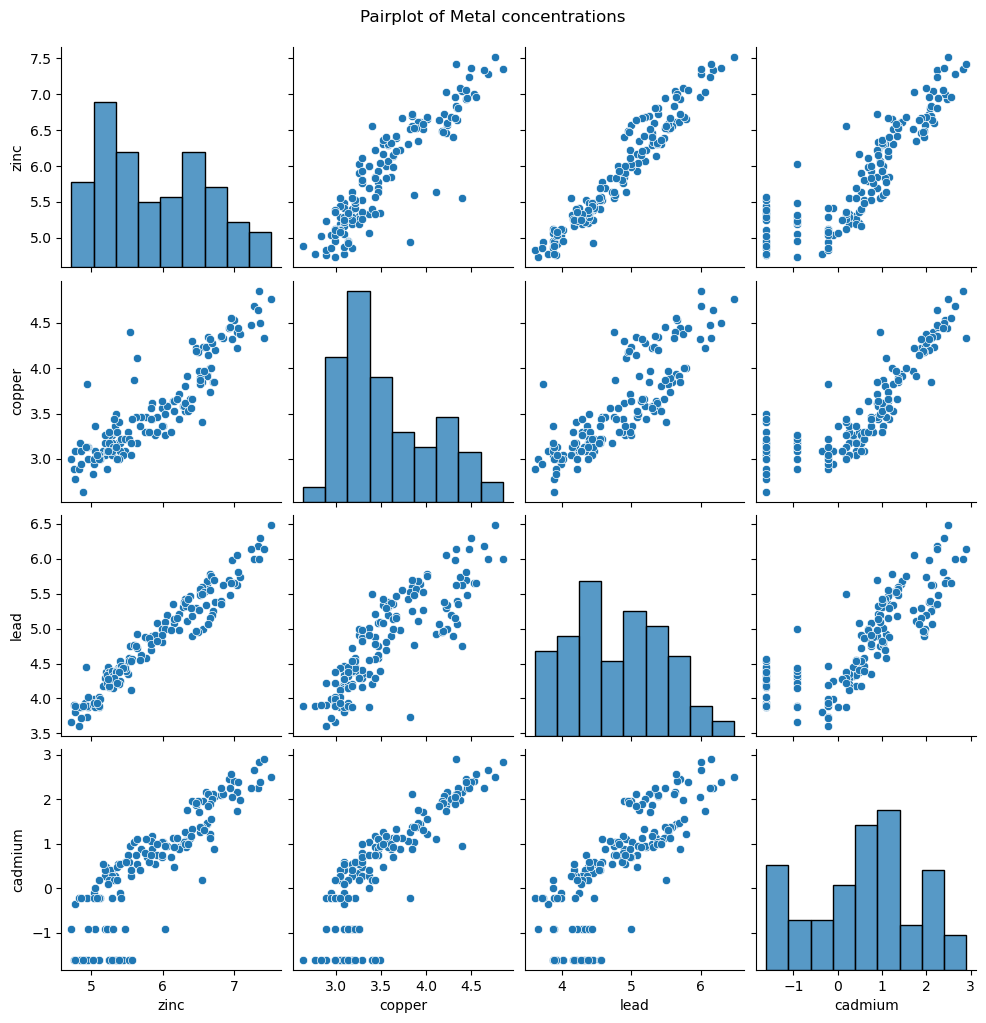

In [21]:
# Pairplot for the metal elements
selected_vars = ['zinc', 'copper', 'lead', 'cadmium']
sns.pairplot(log_transformed[selected_vars])
plt.suptitle('Pairplot of Metal concentrations', y=1.02)
plt.show()

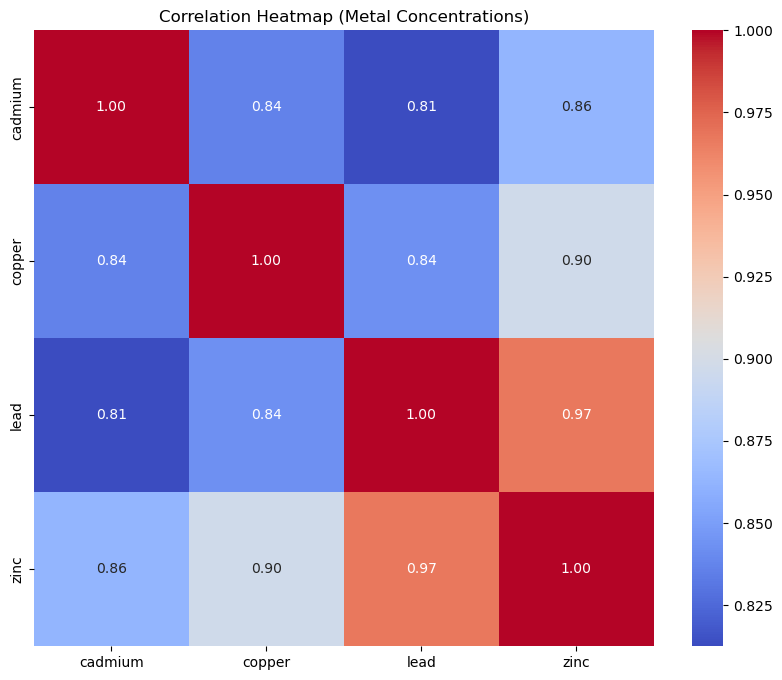

In [22]:
# Correlation heatmap 
selected_variables = ['cadmium', 'copper', 'lead', 'zinc'] 

# Subset the DataFrame based on selected variables
selected_data = log_transformed[selected_variables]

# Calculate the correlation matrix for selected variables
correlation_matrix = selected_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Metal Concentrations)')
plt.show()

In [68]:
meuse_df.describe()

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,dist.m
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,153.000000,155.000000,155.000000,155.000000,155.000000
mean,180004.600000,331634.935484,3.245806,40.316129,153.361290,469.716129,8.165394,0.240017,7.478431,1.606452,1.451613,0.283871,290.322581
std,746.039775,1047.746801,3.523746,23.680436,111.320054,367.073788,1.058657,0.197702,3.432966,0.734111,0.636483,0.452336,226.799927
min,178605.000000,329714.000000,0.200000,14.000000,37.000000,113.000000,5.180000,0.000000,1.000000,1.000000,1.000000,0.000000,10.000000
25%,179371.000000,330762.000000,0.800000,23.000000,72.500000,198.000000,7.546000,0.075687,5.300000,1.000000,1.000000,0.000000,80.000000
50%,179991.000000,331633.000000,2.100000,31.000000,123.000000,326.000000,8.180000,0.211843,6.900000,1.000000,1.000000,0.000000,270.000000
75%,180629.500000,332463.000000,3.850000,49.500000,207.000000,674.500000,8.955000,0.364067,9.000000,2.000000,2.000000,1.000000,450.000000
max,181390.000000,333611.000000,18.100000,128.000000,654.000000,1839.000000,10.520000,0.880389,17.000000,3.000000,3.000000,1.000000,1000.000000


In [25]:
meuse_df['x']

0      181072
1      181025
2      181165
3      181298
4      181307
        ...  
150    179184
151    179085
152    178875
153    179466
154    180627
Name: x, Length: 155, dtype: int64

In [26]:
meuse_df['y']

0      333611
1      333558
2      333537
3      333484
4      333330
        ...  
150    330182
151    330292
152    330311
153    330381
154    330190
Name: y, Length: 155, dtype: int64